C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1302919036.py:124: ComplexWarning: Casting complex values to real discards the imaginary part
  f_ext1  = extension_matrix.astype(prec)  @ f_phys.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1302919036.py:125: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff1  = expansion_matrix.astype(prec)  @ f_phys.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1302919036.py:127: ComplexWarning: Casting complex values to real discards the imaginary part
  f_ext2  = polynomial_matrix.astype(prec) @ coeff1.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1302919036.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  f_ext3  = extension_matrix.astype(prec)  @ f_phys.astype(prec)
C:\Users\TE\AppData\Local\Temp\ipykernel_31660\1302919036.py:135: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff2  = expansion_matrix.astype

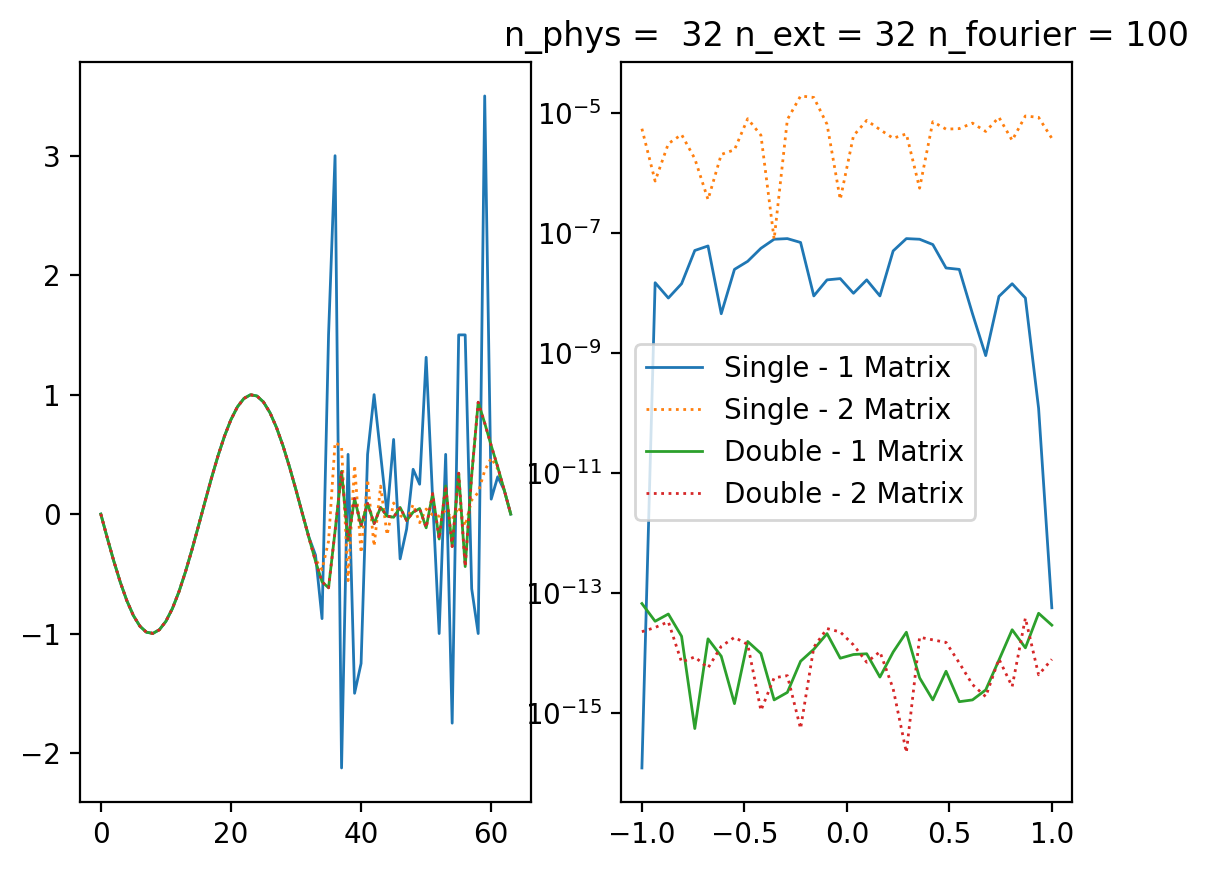

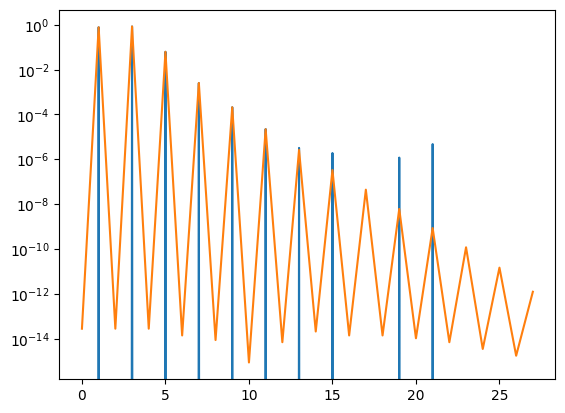

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
import mpmath as mp

# Set the precision for mpmath
mp.dps = 64

# Define the mapping function
def mapping(x, alpha):
    return mp.sin(alpha * mp.pi * x / 2) / mp.sin(alpha * mp.pi / 2)

# Define the function to compute weights μm
def compute_weights(zm, alpha):
    mu = mp.matrix(len(zm), 1)
    for n in range(len(zm)):
        if n == 0:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n+1], alpha)) - mp.asin(mapping(zm[n], alpha)))
        elif n == len(zm) - 1:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n], alpha)) - mp.asin(mapping(zm[n-1], alpha)))
        else:
            mu[n] = (1/2) * (mp.asin(mapping(zm[n+1], alpha)) - mp.asin(mapping(zm[n-1], alpha)))
    return mu

# Define the basis functions φn(x)
def phi_n(x, n, alpha):
    cn = mp.sqrt(1/mp.pi) if n == 0 else mp.sqrt(2/mp.pi)
    return cn * mp.cos(n * mp.acos(mapping(x, alpha)))

# Function to create the MPA expansion matrix
def create_expansion_matrix(alpha, N, n_order, cutoff=0):
    # Create the grid points zm
    zm = mp.linspace(-1, 1, N)

    # Compute the weights μm
    mu = compute_weights(zm, alpha)
    sqrt_mu = mp.matrix(len(mu), 1)
    for i in range(len(mu)):
        sqrt_mu[i] = mp.sqrt(mu[i])

    # Create the matrix A
    A = mp.matrix(N, n_order)
    for m in range(N):
        for n in range(n_order):
            A[m, n] = sqrt_mu[m] * phi_n(zm[m], n, alpha)

    # Compute the SVD of A
    U, s, Vh = mp.svd(A, full_matrices=False)
    sinv = mp.diag([1 / si if si > cutoff else 0 for si in s])  # Inverted singular values matrix with cutoff

    # Construct the expansion matrix
    expansion_matrix = Vh.T * sinv * U.T * mp.diag(sqrt_mu)

    return expansion_matrix

# Function to create the interpolation matrix
def create_interpolation_matrix(alpha, N, n_order, N_interpolated):
    expansion_matrix = create_expansion_matrix(alpha, N, n_order)

    # Create the interpolation points
    z_interpolated = mp.linspace(-1, 1, N_interpolated)

    # Create the matrix Phi for the interpolated points
    Phi_interpolated = mp.matrix(N_interpolated, n_order)
    for i in range(N_interpolated):
        for n in range(n_order):
            Phi_interpolated[i, n] = phi_n(z_interpolated[i], n, alpha)

    interpolation_matrix = Phi_interpolated * expansion_matrix

    return interpolation_matrix

# Function to compute accurate SVD extensions of mapped polynomials
def compute_svd_fourier_extension(n_coll, n_ext, n_phys, n_fourier, cutoff=0):
    """
    Computes the Fourier extension using Singular Value Decomposition (SVD).

    Parameters:
    n_coll (int): Number of overcollocation points.
    n_phys (int): Number of physical grid points.
    n_ext (int): Number of extension grid points.
    n_fourier (int): Number of Fourier modes.
    precision (int, optional): Precision for mpmath calculations. Default is 64.
    cutoff (float, optional): Cutoff value for singular values. Default is 0.

    Returns:
    tuple: Tuple containing the interpolated matrix, extended grid points, and grid spacing.
    """
    L_phys  = mp.mpf(2)
    dx_coll = L_phys / (n_coll - 1)  # Grid spacing for collocation points
    dx_phys = L_phys / (n_phys - 1)  # Grid spacing for physical points
    L_ext   = dx_phys * n_ext        # Extension domain length
    ks      = np.arange(-int(n_fourier / 2) + 1, int(n_fourier / 2) + 1)  # Fourier modes
    x_coll  = mp.matrix([i * dx_coll for i in range(n_coll)])  # Collocation grid points

    # Construct the matrix M
    M = mp.matrix(n_coll, len(ks))
    for i in range(n_coll):
        for j in range(len(ks)):
            M[i, j] = mp.exp(1j * ks[j] * 2 * mp.pi / (L_phys + L_ext) * x_coll[i])

    # Perform SVD on the matrix M
    U, s, Vh = mp.svd(M)
    sinv = mp.diag([1 / si if si > cutoff else 0 for si in s])  # Inverted singular values matrix with cutoff
    M_inv = Vh.H * sinv * U.H

    # Extended grid points
    x_ext = mp.matrix([i * dx_phys for i in range(n_ext + n_phys)])

    # Construct the extended function
    rec = mp.matrix(len(x_ext), len(ks))
    for i in range(len(x_ext)):
        for j in range(len(ks)):
            rec[i, j] = mp.exp(1j * ks[j] * 2 * mp.pi / (L_phys + L_ext) * x_ext[i])

    M_int = rec * M_inv
    return M_int

# Test function
f = lambda x: np.sin(np.pi * x)

# Example usage
# Parameters (adjust as necessary to match the parameters used when saving the file)
alpha  = 0.5
n_phys = 32
n_ext  = 32
n_order  = 28
n_coll = 300
n_fourier = 100
x_phys = mp.linspace(-1, 1, n_phys)
x_coll = mp.linspace(-1, 1, n_coll)

precision = 64
cutoff = 1e-16

# Compute basis function values for extension
mapped_polynomials = mp.matrix([[phi_n(mp.mpf(x), order, alpha) for x in x_coll] for order in n_order])

# Matrix that expands input function of length n_phys in terms of mapped polynomials using SVD
# Returns n_order weights.
expansion_matrix   = create_expansion_matrix(alpha, n_phys, n_order)


# Combine both methods
def combined_approximation(f_phys, alpha, M, N, basis_functions):
    # Step 1: Interpolate using MPA
    expansion_matrix = create_expansion_matrix(alpha, M, N)

    # Step 2: Extend using periodic basis
    extension_matrix = mp.matrix(basis_functions.T) * expansion_matrix

    return extension_matrix, mp.matrix(basis_functions.T), expansion_matrix

# Combined approximation
extension_matrix, polynomial_matrix, expansion_matrix = combined_approximation(f_phys, alpha, M, N, basis_functions)

# Convert to NumPy arrays for plotting
extension_matrix, polynomial_matrix, expansion_matrix = np.array(extension_matrix.tolist(), dtype=complex), np.array(polynomial_matrix.tolist(), dtype=complex), np.array(expansion_matrix.tolist(), dtype=complex)
